# Using Isochrone Maps to Show Grocery Store Access

By Christopher Do

This week, I'm going to do some brief cleaning up of the grocery store notebook to include wards, and then I will attempt to apply the isochrone maps we learned about in class to a grocery store location in DC (Safeway in Ward 7). Ideally, I would map grocery stores across DC using walking and driving distances. Eventually, I would incorporate bus stops as well as nodes within a certain radius, though this might be more complicated based on different bus routes. This week will just be a start on this project.

Note that the rest of my group is cleaning up the data we are using for other parts of the final already, which overlap with the data I used, and we decided that since the previous notebook on vehicle ownership will be tied into driving distance calculations, I would get working on this part for the final.

Data sources for this week include:

1) Grocery store data pulled from Open Data DC
2) Ward maps from Open Data DC (2012 version, as the 2022 redistricted map has just been released but does not apply to our data set.

## Setting up the data

I'll start by bringing in the libraries.

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import networkx as nx
import contextily as ctx
import plotly.express as px
import osmnx as ox

## Cleaning up the Food Data

I want to bring in the food data first. I will start by cleaning up the data, keeping store names and adding store types, as well as the geometry and location of stores.

In [2]:
grocery = pd.read_csv('data/Grocery_Store_Locations.csv')

To figure out columns and what is included in data:

In [3]:
grocery.shape

(82, 36)

To see what columns/data are included

In [4]:
grocery.head()

X          Y                       STORENAME  \
0 -77.026981  38.984455                         Target    
1 -77.026066  38.983464  International Progresso Market   
2 -77.027798  38.967771               Jocelyn’s Market    
3 -77.076459  38.965553                      Magruder's   
4 -77.074910  38.964601                         Safeway   

                      ADDRESS  ZIPCODE       PHONE    WARD           SSL  \
0      7828 GEORGIA AVENUE NW    20012  2028923822  Ward 4  2960    0017   
1      7719 GEORGIA AVENUE NW    20012  2025455015  Ward 4  2961    0810   
2      6404 GEORGIA AVENUE NW    20012  2027227574  Ward 4  2945    0839   
3  5626 CONNECTICUT AVENUE NW    20015  2024644946  Ward 3  1860    0013   
4  5545 CONNECTICUT AVENUE NW    20015  2022446097  Ward 3  1867    0092   

  NOTES PRESENT90  ...     XCOORD     YCOORD  MAR_ID SE_ANNO_CAD_DATA  \
0   NaN       NaN  ...  397662.57  146280.07  300512              NaN   
1   NaN       NaN  ...  397741.80  146169.97  285417              NaN   
2   NaN       NaN  ...  397591.16  144428.00  285334              NaN   
3             Yes  ...  393373.92  144184.19  263860              NaN   
4              No  ...  393508.13  144078.34  263999              NaN   

                                 GLOBALID CREATOR                 CREATED  \
0  {CE302122-4E8D-4DC7-845B-06563B993F66}    JLAY  2022/09/28 18:04:54+00   
1  {2C18863D-40DE-4F66-AA59-46F1C65D67F2}    JLAY  2022/09/28 18:04:54+00   
2  {A0B448C3-B3FB-49FE-B8BF-1FEBA3CEA642}    JLAY  2022/09/28 18:04:54+00   
3  {9ABE1C46-BB48-4110-B5BA-C6363CA3BD7A}    JLAY  2022/09/28 18:04:54+00   
4  {902F540E-FE16-43A5-8010-CD84E94B28B7}    JLAY  2022/09/28 18:04:54+00   

  EDITOR                  EDITED PRESENT22  
0   JLAY  2022/09/28 18:04:54+00       Yes  
1   JLAY  2022/09/28 18:04:54+00       Yes  
2   JLAY  2022/09/28 18:04:54+00       Yes  
3   JLAY  2022/09/28 18:04:54+00       Yes  
4   JLAY  2022/09/28 18:04:54+00       Yes  

[5 rows x 36 columns]

I want to see all columns displayed so I don't miss anything:

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
grocery.head()

X          Y                       STORENAME  \
0 -77.026981  38.984455                         Target    
1 -77.026066  38.983464  International Progresso Market   
2 -77.027798  38.967771               Jocelyn’s Market    
3 -77.076459  38.965553                      Magruder's   
4 -77.074910  38.964601                         Safeway   

                      ADDRESS  ZIPCODE       PHONE    WARD           SSL  \
0      7828 GEORGIA AVENUE NW    20012  2028923822  Ward 4  2960    0017   
1      7719 GEORGIA AVENUE NW    20012  2025455015  Ward 4  2961    0810   
2      6404 GEORGIA AVENUE NW    20012  2027227574  Ward 4  2945    0839   
3  5626 CONNECTICUT AVENUE NW    20015  2024644946  Ward 3  1860    0013   
4  5545 CONNECTICUT AVENUE NW    20015  2022446097  Ward 3  1867    0092   

  NOTES PRESENT90 PRESENT95 PRESENT00 PRESENT05 PRESENT08 PRESENT09 PRESENT10  \
0   NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1   NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2   NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3             Yes       Yes       Yes       Yes       Yes       Yes       Yes   
4              No       Yes       Yes       Yes       Yes       Yes       Yes   

  PRESENT11 PRESENT12 PRESENT13 PRESENT14 PRESENT15 PRESENT16 PRESENT17  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3       Yes       Yes       Yes       Yes       Yes       Yes       Yes   
4       Yes       Yes       Yes       Yes       Yes       Yes       Yes   

  PRESENT18            GIS_ID  OBJECTID     XCOORD     YCOORD  MAR_ID  \
0       NaN  GroceryStorePt_1       641  397662.57  146280.07  300512   
1       NaN  GroceryStorePt_2       642  397741.80  146169.97  285417   
2       NaN  GroceryStorePt_3       643  397591.16  144428.00  285334   
3       Yes  GroceryStorePt_4       644  393373.92  144184.19  263860   
4       Yes  GroceryStorePt_5       645  393508.13  144078.34  263999   

   SE_ANNO_CAD_DATA                                GLOBALID CREATOR  \
0               NaN  {CE302122-4E8D-4DC7-845B-06563B993F66}    JLAY   
1               NaN  {2C18863D-40DE-4F66-AA59-46F1C65D67F2}    JLAY   
2               NaN  {A0B448C3-B3FB-49FE-B8BF-1FEBA3CEA642}    JLAY   
3               NaN  {9ABE1C46-BB48-4110-B5BA-C6363CA3BD7A}    JLAY   
4               NaN  {902F540E-FE16-43A5-8010-CD84E94B28B7}    JLAY   

                  CREATED EDITOR                  EDITED PRESENT22  
0  2022/09/28 18:04:54+00   JLAY  2022/09/28 18:04:54+00       Yes  
1  2022/09/28 18:04:54+00   JLAY  2022/09/28 18:04:54+00       Yes  
2  2022/09/28 18:04:54+00   JLAY  2022/09/28 18:04:54+00       Yes  
3  2022/09/28 18:04:54+00   JLAY  2022/09/28 18:04:54+00       Yes  
4  2022/09/28 18:04:54+00   JLAY  2022/09/28 18:04:54+00       Yes

To see what type of information is in each column:

In [7]:
grocery.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   X                 82 non-null     float64
 1   Y                 82 non-null     float64
 2   STORENAME         82 non-null     object 
 3   ADDRESS           82 non-null     object 
 4   ZIPCODE           82 non-null     int64  
 5   PHONE             82 non-null     int64  
 6   WARD              82 non-null     object 
 7   SSL               82 non-null     object 
 8   NOTES             53 non-null     object 
 9   PRESENT90         55 non-null     object 
 10  PRESENT95         55 non-null     object 
 11  PRESENT00         55 non-null     object 
 12  PRESENT05         55 non-null     object 
 13  PRESENT08         55 non-null     object 
 14  PRESENT09         55 non-null     object 
 15  PRESENT10         55 non-null     object 
 16  PRESENT11         55 non-null     object 
 17 

I will add a new column, "Store Type" to help distinguish this data set from the healthy corner store and farmers market data.

In [8]:
grocery['STORE TYPE']= 'Grocery store' # create a new column "store type"

There are a lot of columns that I won't need so I will clean those up now.

In [9]:
#subsetting the data
desired_columns = ['X','Y','STORENAME','WARD', 'STORE TYPE']
grocery_trimmed = grocery[desired_columns].copy()
grocery_trimmed = grocery_trimmed.dropna()
grocery_trimmed.sample

<bound method NDFrame.sample of             X          Y                       STORENAME    WARD  \
0  -77.026981  38.984455                         Target   Ward 4   
1  -77.026066  38.983464  International Progresso Market  Ward 4   
2  -77.027798  38.967771               Jocelyn’s Market   Ward 4   
3  -77.076459  38.965553                      Magruder's  Ward 3   
4  -77.074910  38.964601                         Safeway  Ward 3   
5  -77.027285  38.962078             Walmart Supercenter  Ward 4   
6  -77.002144  38.957977             Walmart Supercenter  Ward 4   
7  -77.021318  38.956604   Tropimart International Foods  Ward 4   
8  -77.083861  38.956303                       Rodman’s   Ward 3   
9  -77.012301  38.951416                   Avenue Market  Ward 4   
10 -77.079215  38.949109                     Whole Foods  Ward 3   
11 -77.080552  38.948537                         Target   Ward 3   
12 -77.095759  38.945722               Wagshal’s Market   Ward 3   
13 -77.063173  3

Confirming that new variable looks good

In [10]:
grocery_trimmed.head()

X          Y                       STORENAME    WARD     STORE TYPE
0 -77.026981  38.984455                         Target   Ward 4  Grocery store
1 -77.026066  38.983464  International Progresso Market  Ward 4  Grocery store
2 -77.027798  38.967771               Jocelyn’s Market   Ward 4  Grocery store
3 -77.076459  38.965553                      Magruder's  Ward 3  Grocery store
4 -77.074910  38.964601                         Safeway  Ward 3  Grocery store

First, though, I want to make sure I have a DC ward map to overlay on top to show ward boundaries.

In [11]:
wards=gpd.read_file('data/Wards_from_2012.geojson')

Let's make sure the ward information was brought in with all the information we need.

In [12]:
wards.head()

OBJECTID  WARD    NAME              REP_NAME  \
0         1     6  Ward 6         Charles Allen   
1         2     8  Ward 8     Trayon White, Sr.   
2         3     4  Ward 4  Janeese Lewis George   
3         4     3  Ward 3          Mary M. Cheh   
4         5     5  Ward 5       Kenyan McDuffie   

                                             WEB_URL       REP_PHONE  \
0  https://www.dccouncil.us/council/councilmember...  (202) 724-8072   
1  https://www.dccouncil.us/council/councilmember...  (202) 724-8045   
2  https://dccouncil.us/council/ward-4-councilmem...  (202) 724-8052   
3  https://www.dccouncil.us/council/council-membe...  (202) 724-8062   
4       https://dccouncil.us/council/kenyan-mcduffie  (202) 724-8028   

                   REP_EMAIL                                  REP_OFFICE  \
0        callen@dccouncil.us  1350 Pennsylvania Ave, Suite 406, NW 20004   
1        twhite@dccouncil.us  1350 Pennsylvania Ave, Suite 400, NW 20004   
2  jlewisgeorge@dccouncil.us  1350 Pennsylvania Ave, Suite 105, NW 20004   
3         mcheh@dccouncil.us  1350 Pennsylvania Ave, Suite 108, NW 20004   
4     kmcduffie@dccouncil.us  1350 Pennsylvania Ave, Suite 506, NW 20004   

  WARD_ID   LABEL   AREASQMI  POP_2000  POP_2010  POP_2011_2015 POP_BLACK  \
0       6  Ward 6   6.221045     70867     76238          84290     29909   
1       8  Ward 8  11.937871     74049     73662          81133     75259   
2       4  Ward 4   9.001942     75179     75773          83066     46884   
3       3  Ward 3  10.934713     75335     78887          83152      5730   
4       5  Ward 5  10.390304     71440     74308          82049     57733   

  POP_NATIVE_AMERICAN POP_ASIAN POP_HAWAIIAN POP_OTHER_RACE TWO_OR_MORE_RACES  \
0                 295      3573           40           1233              2529   
1                 110       310           12            711               872   
2                 519      1755           31           9627              2287   
3                 163      5188            0           1864              3345   
4                 335      1622            9           3758              1915   

  NOT_HISPANIC_OR_LATINO HISPANIC_OR_LATINO POP_MALE POP_FEMALE AGE_0_5  \
0                  79000               5290    40411      43879    4779   
1                  79843               1290    35573      45560    7879   
2                  66565              16501    40349      42717    5602   
3                  74944               8208    37151      46001    4259   
4                  75058               6991    38692      43357    5778   

  AGE_5_9 AGE_10_14 AGE_15_17 AGE_18_19 AGE_20 AGE_21 AGE_22_24 AGE_25_29  \
0    2747      2235      1088      1370    794    724      4596     13427   
1    7061      5963      3596      2945   1800   1748      4070      6306   
2    4421      4210      2467      1379    668    668      2893      7039   
3    4077      2814      1588      3526   1497   1499      3849      8672   
4    3972      2654      2249      2817   1533   1531      3882      8514   

  AGE_30_34 AGE_35_39 AGE_40_44 AGE_45_49 AGE_50_54 AGE_55_59 AGE_60_61  \
0     12512      8052      5474      4524      4350      4724      1830   
1      5951      4617      4873      4429      4978      5001      1578   
2      7149      5913      5760      6406      6003      5783      2078   
3      7374      6069      5496      5025      5201      4388      1992   
4      7439      5996      5228      4828      4905      5274      1736   

  AGE_65_66 AGE_67_69 AGE_70_74 AGE_75_79 AGE_80_84 AGE_85_PLUS MEDIAN_AGE  \
0      1518      1596      2167      1522       816         958       33.9   
1      1011      1211      1904      1026       634         432       29.3   
2      1513      1859      2296      2063      1753        2407       39.3   
3      1574      2602      3343      2545      1349        1837         37   
4      1108      1640      2361      2079      1947        2135       35.4   

  UNEMPLOYMENT_RATE TO

There's a lot of cool information here but I think I'll only need 'WARD' and 'geometry' so I'll cut out the rest.

In [13]:
trim_columns=['WARD','geometry']
wards_trimmed = wards[trim_columns].copy()
wards_trimmed = wards_trimmed.dropna()
wards_trimmed.sample

<bound method NDFrame.sample of    WARD                                           geometry
0     6  POLYGON ((-77.01790 38.91410, -77.01801 38.914...
1     8  POLYGON ((-76.97229 38.87286, -76.97240 38.872...
2     4  POLYGON ((-77.04097 38.99597, -77.07174 38.971...
3     3  POLYGON ((-77.05808 38.95676, -77.05809 38.956...
4     5  POLYGON ((-76.99144 38.95730, -76.99163 38.957...
5     1  POLYGON ((-77.03523 38.93743, -77.03570 38.937...
6     2  POLYGON ((-77.04946 38.91999, -77.04973 38.920...
7     7  POLYGON ((-76.94186 38.91854, -76.94200 38.918...>

Now let's see what the ward boundaries look like...

<AxesSubplot: >

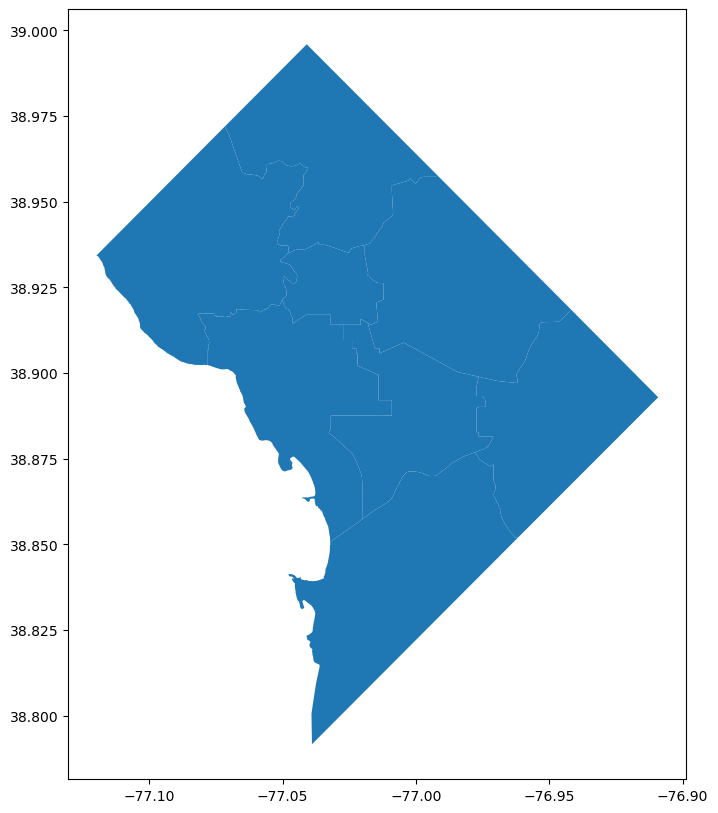

In [14]:
wards_trimmed.plot(figsize=(12,10))

Let's double check the projections to make sure we're all on the same page.

In [15]:
wards_trimmed.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now that this is simplified and in 4326, let's use it as an overlay on other maps.

## Mapping grocery store locations

Now let's bring back the trimmed grocery store data and convert it into a geodata frame. I'll set the crs to 4326.

In [16]:
gdf = gpd.GeoDataFrame(grocery_trimmed, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(grocery_trimmed.X, grocery_trimmed.Y))

Now let's use this and the ward data to map grocery store locations! I'm going to set the ward map as a base map, make the markers green, and hopefully it'll look right.

Text(0.5, 1.0, 'Grocery Store Locations by Ward')

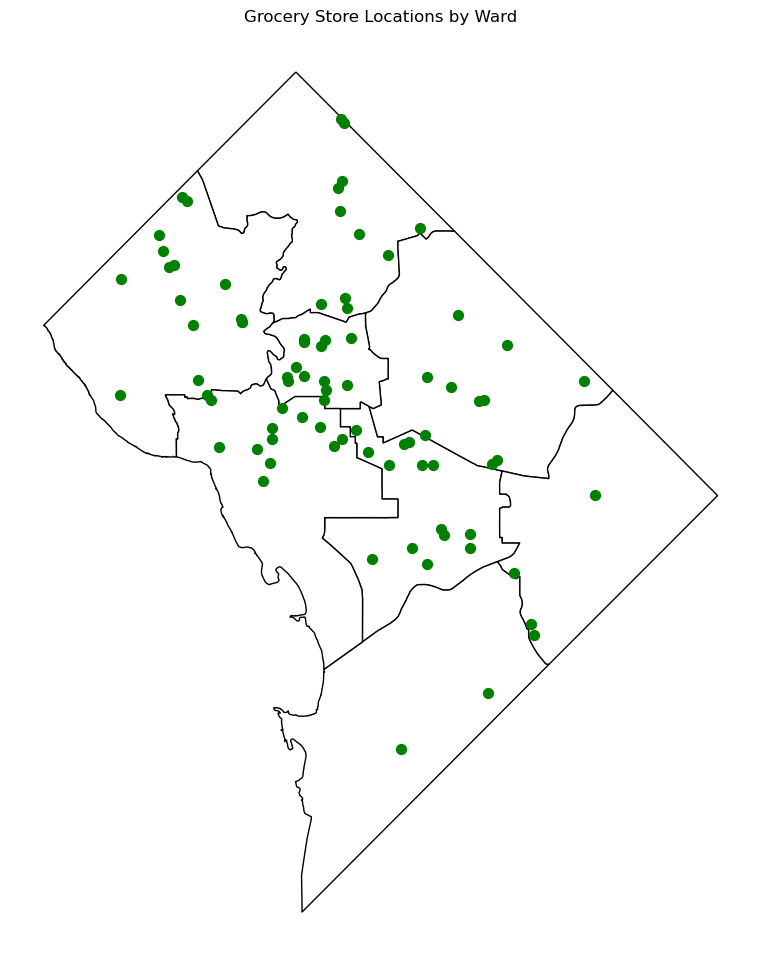

In [17]:
fig, ax = plt.subplots(figsize=(12,12))

wards_trimmed.plot(ax=ax,
                   color='white', 
                   edgecolor='black')

# add the data options, marker is an X, markersize is 10, and color is red
gdf.plot(ax=ax, 
        marker='o',
        markersize=50,
        color='green')

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Grocery Store Locations by Ward')

Could this map be useful? Yes, I think showing the ward boundaries is useful for contextualizing the distribution around parts of DC and helps to organize the information. I don't think I'll use this map in the final, but it drives home the concentration of grocery stores in certain areas of DC.

Now to make it more complex by adding the map in folium and making it interactive.

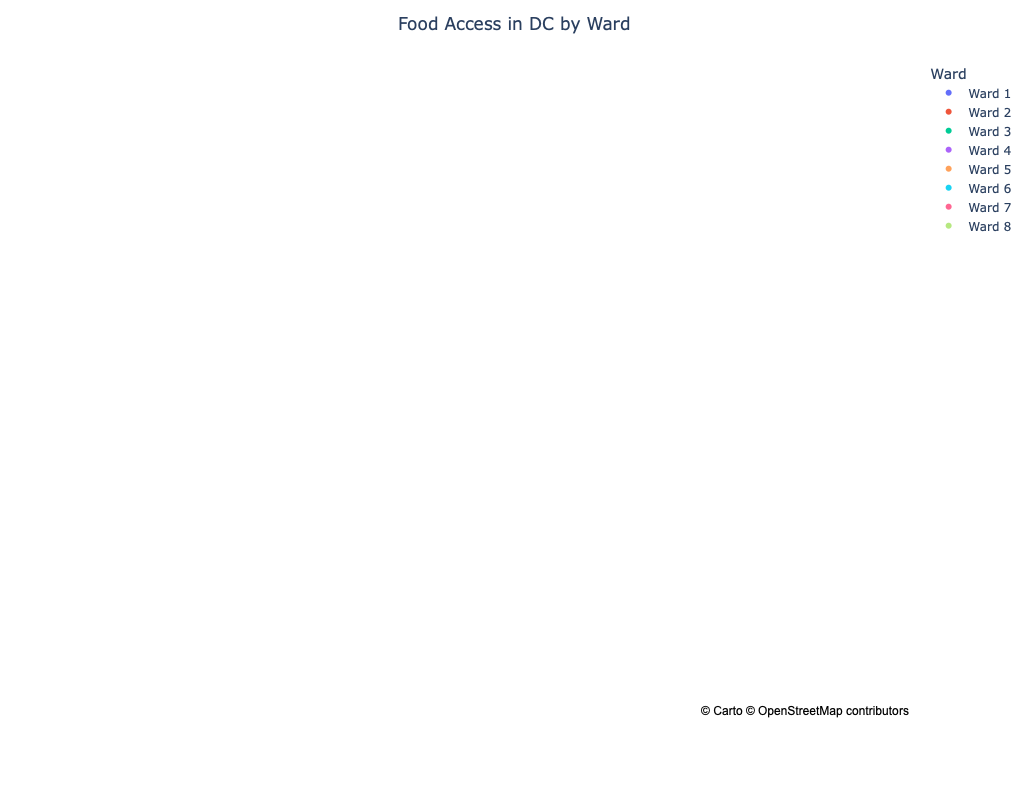

In [18]:
fig = px.scatter_mapbox(grocery_trimmed,
                        lat="Y",
                        lon="X",
                        color="WARD",
                        labels={"STORENAME": "Store Name", "WARD": "Ward"},
                        mapbox_style="carto-positron",
                        category_orders={'WARD':['Ward 1','Ward 2','Ward 3','Ward 4', 'Ward 5', 'Ward 6', 'Ward 7', 'Ward 8']}
                       )

# options on the layout
fig.update_layout(
    width = 800,
    height = 800,
    title = "Food Access in DC by Ward",
    title_x=0.5 
)


fig.show()

I think this map is going to be useful for illustrating the disparities around DC with grocery store access. The one problem I have with this map is I'm unable to map ward boundaries on top of it? If that were added, I think that would be very helpful to keep consistency across our maps and show the context of DC.

# Mapping walking distances as isochrone maps

Now, I want to create an isochrone map that will display what is within walking distance of a grocery store.. I will first use osmnx.graph.graph_from_point to define the walking networks within 5, 10, and 15 minutes of each grocery store.

## Setting up the data

To begin, I want to just pull the grocery stores from wards 7 and 8. I want their coordinates so I can map them as points.

In [19]:
grocery_trimmed[grocery_trimmed['WARD']=='Ward 7']

X          Y     STORENAME    WARD     STORE TYPE  \
66 -76.966673  38.859032       Safeway  Ward 7  Grocery store   
77 -76.947457  38.893140       Safeway  Ward 7  Grocery store   
78 -76.972748  38.874133  Yes! Organic  Ward 7  Grocery store   
80 -76.967401  38.861766          Lidl  Ward 7  Grocery store   

                      geometry  
66  POINT (-76.96667 38.85903)  
77  POINT (-76.94746 38.89314)  
78  POINT (-76.97275 38.87413)  
80  POINT (-76.96740 38.86177)

In [20]:
grocery_trimmed[grocery_trimmed['WARD']=='Ward 8']

X          Y           STORENAME    WARD     STORE TYPE  \
62 -77.004713  38.880285  Whole Foods Market  Ward 8  Grocery store   
65 -77.000097  38.876224       Harris Teeter  Ward 8  Grocery store   
67 -76.980999  38.844949               Giant  Ward 8  Grocery store   
81 -77.008082  38.831205   Good Food Markets  Ward 8  Grocery store   

                      geometry  
62  POINT (-77.00471 38.88029)  
65  POINT (-77.00010 38.87622)  
67  POINT (-76.98100 38.84495)  
81  POINT (-77.00808 38.83120)

Now that I have those values, I want to save this subset of data as variables.

In [21]:
ward_7=grocery_trimmed[grocery_trimmed['WARD']=='Ward 7']
ward_8=grocery_trimmed[grocery_trimmed['WARD']=='Ward 8']

Now I want to use Safeway in Ward 7 as an example of a point to use to create an isochrone map.

In [22]:
latlon=[38.859032,-76.966673]
network_type = 'walk'
trip_times = [5,10,15]
meters_per_minute = 75

Okay, now that we have the Safeway down for Ward 7, I want to use it to create a variable G, which will graph the points in the network. 

In [23]:
G = ox.graph_from_point(latlon, network_type=network_type, dist = 2000)

Now, let's switch to a coordinate system to make it easier to measure distances.

In [24]:
G = ox.project_graph(G, to_crs='epsg:3857')

Next, I'll convert it into a geodata frame that extracts the nodes and edges we will need to define the street network.

In [25]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

Let's double check and see if the right points came through for the nodes.

In [26]:
gdf_nodes.sample(10)

y             x  street_count        lon        lat  \
osmid                                                                         
8731842303   4.699470e+06 -8.570325e+06             4 -76.988539  38.844835   
3659338741   4.700246e+06 -8.566335e+06             3 -76.952696  38.850264   
1533381781   4.699849e+06 -8.566508e+06             3 -76.954255  38.847489   
9384640838   4.700183e+06 -8.568562e+06             4 -76.972701  38.849822   
49774243     4.701554e+06 -8.566878e+06             4 -76.957576  38.859418   
5453970838   4.702862e+06 -8.568064e+06             1 -76.968227  38.868562   
9072318954   4.699250e+06 -8.568095e+06             4 -76.968509  38.843294   
1493945520   4.702530e+06 -8.568744e+06             1 -76.974335  38.866243   
10088158896  4.703355e+06 -8.565650e+06             3 -76.946544  38.872010   
646190836    4.703483e+06 -8.568157e+06             3 -76.969067  38.872904   

              highway                          geometry  
osmid                                                    
8731842303   crossing  POINT (-8570324.903 4699469.826)  
3659338741        NaN  POINT (-8566334.889 4700245.800)  
1533381781        NaN  POINT (-8566508.459 4699849.165)  
9384640838        NaN  POINT (-8568561.858 4700182.635)  
49774243          NaN  POINT (-8566878.173 4701554.395)  
5453970838        NaN  POINT (-8568063.870 4702861.613)  
9072318954   crossing  POINT (-8568095.196 4699249.561)  
1493945520        NaN  POINT (-8568743.743 4702530.128)  
10088158896       NaN  POINT (-8565650.141 4703354.664)  
646190836         NaN  POINT (-8568157.379 4703482.549)

Looks good! Let's see what the nodes look like:

<AxesSubplot: >

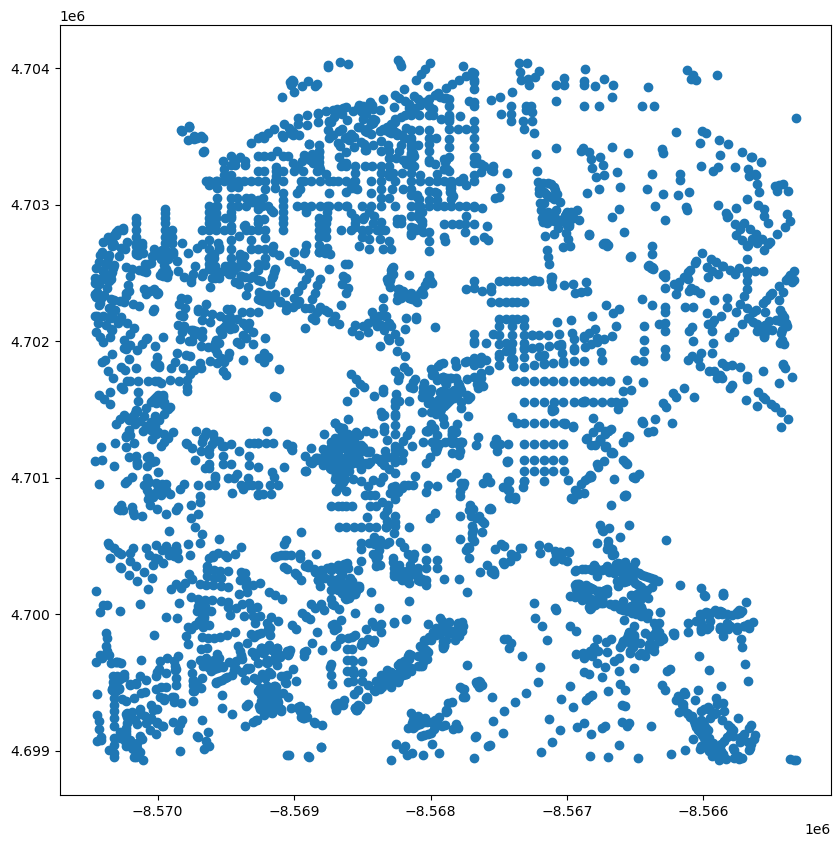

In [27]:
gdf_nodes.plot(figsize=(10,10))

So that could be anything, but it looks cool. Now I want to double check the edges to see what the street networks are and make sure we can use then to calculate walking distances.

In [28]:
gdf_edges.head()

osmid lanes                    name  \
u          v          key                                            
49716932   1460636998 0      6051305     2  Pomeroy Road Southeast   
           1460627779 0    131520167   NaN   Morris Road Southeast   
           49827240   0    590598879   NaN   Morris Road Southeast   
1460636998 49716936   0      6051305     2  Pomeroy Road Southeast   
           49716932   0      6051305     2  Pomeroy Road Southeast   

                               highway  oneway reversed   length  \
u          v          key                                          
49716932   1460636998 0    residential   False    False   42.492   
           1460627779 0    residential   False    False   97.018   
           49827240   0    residential   False    False  109.962   
1460636998 49716936   0    residential   False    False   34.326   
           49716932   0    residential   False     True   42.492   

                                                                    geometry  \
u          v          key                                                      
49716932   1460636998 0    LINESTRING (-8569885.024 4701331.783, -8569922...   
           1460627779 0    LINESTRING (-8569885.024 4701331.783, -8569815...   
           49827240   0    LINESTRING (-8569885.024 4701331.783, -8569912...   
1460636998 49716936   0    LINESTRING (-8569922.216 4701291.770, -8569952...   
           49716932   0    LINESTRING (-8569922.216 4701291.770, -8569885...   

                          service maxspeed access width bridge junction  ref  \
u          v          key                                                      
49716932   1460636998 0       NaN      NaN    NaN   NaN    NaN      NaN  NaN   
           1460627779 0       NaN      NaN    NaN   NaN    NaN      NaN  NaN   
           49827240   0       NaN      NaN    NaN   NaN    NaN      NaN  NaN   
1460636998 49716936   0       NaN      NaN    NaN   NaN    NaN      NaN  NaN   
           49716932   0       NaN      NaN    NaN   NaN    NaN      NaN  NaN   

                          tunnel  
u          v          key         
49716932   1460636998 0      NaN  
           1460627779 0      NaN  
           49827240   0      NaN  
1460636998 49716936   0      NaN  
           49716932   0      NaN

Ooh I recognize some of these roads! Now let's map the edges.

<AxesSubplot: >

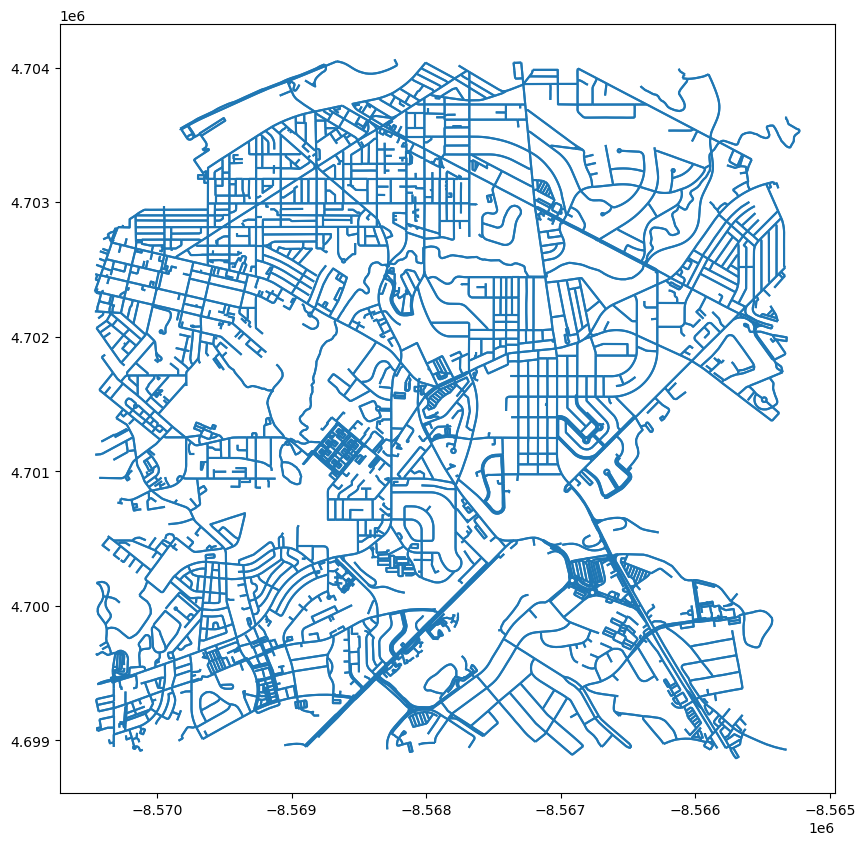

In [29]:
gdf_edges.plot(figsize=(10,10))

I love how abstract road networks look taken out of context.

In [30]:
## Finding the Nearest Node to Safeway, Ward 7

In [31]:
safeway_node = ox.distance.nearest_nodes(G,Y=38.859032,X=-76.966673)
print('The id for the nearest node is ' + str(safeway_node))

The id for the nearest node is 5493245787


Let's then use this node number to figure out the location that we will be mapping from:

In [32]:
gdf_nodes.loc[[safeway_node]]

y             x  street_count        lon        lat  \
osmid                                                                        
5493245787  4.698932e+06 -8.565322e+06             3 -76.943596  38.841068   

           highway                          geometry  
osmid                                                 
5493245787     NaN  POINT (-8565321.927 4698931.500)

## Making the Isochrone Maps

I'm going to calculate walk times and then use that to create an isochrome map around Safeway. First, let's create a new column that calculates walking time under the assumption of 75 meters per minute.

In [33]:
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

Now let's double check and see if the times came out accurately:

In [34]:
gdf_edges[['osmid','name','highway','length','walk_time']].sample(10)

osmid                        name      highway  \
u          v          key                                                       
5453970704 5453970705 0    566334313                         NaN      service   
5445468872 5445468880 1    565418592                         NaN      service   
1486578565 49844353   0      6060983       13th Street Southeast  residential   
49745945   5453970881 0    583908665          S Street Southeast  residential   
9384597577 9072318927 0    136470152                         NaN      footway   
1228475999 3854801296 0    382287719                         NaN      service   
49754216   49734791   0      6054379  Maple View Place Southeast  residential   
5441329908 5441329907 0    564843324                         NaN      service   
8784168978 8784169338 0    948893351                         NaN      footway   
2337777148 2337777149 0    224936529                         NaN      service   

                            length  walk_time  
u          v          key                      
5453970704 5453970705 0     15.344   0.204587  
5445468872 5445468880 1    154.114   2.054853  
1486578565 49844353   0     40.286   0.537147  
49745945   5453970881 0     53.374   0.711653  
9384597577 9072318927 0     42.091   0.561213  
1228475999 3854801296 0    183.727   2.449693  
49754216   49734791   0     82.534   1.100453  
5441329908 5441329907 0     20.194   0.269253  
8784168978 8784169338 0      9.790   0.130533  
2337777148 2337777149 0     82.569   1.100920

Now I want to create a color map that reflects distance to the grocery store:

In [35]:
cmap = 'YlGn'

Just want to double check that trip times are 5, 10, and 15 minutes.

In [36]:
trip_times

[5, 10, 15]

Let's use trip times to figure out what colors will be coded in each.

In [37]:
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap=cmap, 
                                start=0, 
                                return_hex=True)
print(trip_times)
print(iso_colors)

[5, 10, 15]
['#ffffe5', '#77c679', '#004529']


I actually want to invert these colors so that the dark green shows 5 minutes (#004529) while the lighter color reflects 15 minutes away. Let's see if the reverse function works...

In [38]:
new_colors=iso_colors.reverse()
print(trip_times)
print(new_colors)

[5, 10, 15]
None


Yeah guess I have to do it manually.

In [39]:
new_colors=['#004529','#77c679','#ffffe5']
print(new_colors)

['#004529', '#77c679', '#ffffe5']


Let's try to zip these now to pair the list of trip times with the assigned colors:

In [40]:
time_color = list(zip(trip_times, new_colors))
time_color

[(5, '#004529'), (10, '#77c679'), (15, '#ffffe5')]

## Coloring Nodes around Safeway in Ward 7

I'll use a loop to color the nodes around Safeway based on walking distance. I'll start by inversing the color order so that 15 minutes is first and then 5 minutes is last.

In [41]:
time_color.reverse()
time_color

[(15, '#ffffe5'), (10, '#77c679'), (5, '#004529')]

We want to create a for loop that connects each node within a time frame to a certain color. We'll create an egograph of nodes within this distance and then update the data frame for gdf_nodes with an associated distance color.

In [42]:
for time, color in list(time_color):
  
    subgraph = nx.ego_graph(G, safeway_node, radius=time,distance='time')

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' minutes ' + color)
    
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = time
        gdf_nodes.loc[node,'color'] = color

There are 110 nodes within 15 minutes #ffffe5
There are 35 nodes within 10 minutes #77c679
There are 11 nodes within 5 minutes #004529


I want to check gdf_nodes for missing values and assign a color to those:

In [43]:
gdf_nodes.sample(10)

y             x  street_count        lon        lat  \
osmid                                                                         
5445925139   4.699192e+06 -8.569834e+06             3 -76.984129  38.842890   
50483631     4.700433e+06 -8.567054e+06             3 -76.959156  38.851574   
876652489    4.701120e+06 -8.566727e+06             3 -76.956214  38.856378   
640712112    4.700092e+06 -8.566785e+06             3 -76.956737  38.849190   
9033683541   4.699728e+06 -8.566361e+06             1 -76.952928  38.846641   
49814843     4.701707e+06 -8.566740e+06             4 -76.956339  38.860487   
49755335     4.699216e+06 -8.570433e+06             3 -76.989512  38.843061   
10088158891  4.701416e+06 -8.566448e+06             1 -76.953711  38.858452   
1493898232   4.700477e+06 -8.568506e+06             3 -76.972203  38.851884   
1486524351   4.699832e+06 -8.569540e+06             3 -76.981487  38.847366   

                     highway                          geometry  time    color  
osmid                                                                          
5445925139               NaN  POINT (-8569834.017 4699191.891)   NaN      NaN  
50483631     traffic_signals  POINT (-8567054.013 4700433.095)   NaN      NaN  
876652489                NaN  POINT (-8566726.578 4701119.798)   NaN      NaN  
640712112                NaN  POINT (-8566784.798 4700092.327)   NaN      NaN  
9033683541               NaN  POINT (-8566360.782 4699728.015)  15.0  #ffffe5  
49814843                 NaN  POINT (-8566740.471 4701707.132)   NaN      NaN  
49755335                 NaN  POINT (-8570433.272 4699216.274)   NaN      NaN  
10088158891              NaN  POINT (-8566447.968 4701416.241)   NaN      NaN  
1493898232               NaN  POINT (-8568506.488 4700477.379)   NaN      NaN  
1486524351               NaN  POINT (-8569539.956 4699831.599)   NaN      NaN

We'll make those nodes outside of the 15-minute radius gray so they are visible.

In [44]:
gdf_nodes['color'].fillna('#cccccc', inplace=True)
gdf_nodes.sample(10)

y             x  street_count        lon        lat  \
osmid                                                                        
5453970621  4.701136e+06 -8.568590e+06             3 -76.972949  38.856488   
8411860377  4.698972e+06 -8.565875e+06             3 -76.948565  38.841349   
8414667577  4.700798e+06 -8.569754e+06             1 -76.983408  38.854126   
49802403    4.702453e+06 -8.568003e+06             3 -76.967679  38.865702   
49827236    4.701450e+06 -8.570017e+06             3 -76.985769  38.858688   
8414667573  4.700736e+06 -8.569703e+06             3 -76.982949  38.853694   
49755341    4.699241e+06 -8.570321e+06             4 -76.988506  38.843236   
3179330954  4.700140e+06 -8.565997e+06             3 -76.949661  38.849523   
5478791086  4.700095e+06 -8.566589e+06             3 -76.954978  38.849211   
9386204597  4.701124e+06 -8.567441e+06             3 -76.962633  38.856409   

           highway                          geometry  time    color  
osmid                                                                
5453970621     NaN  POINT (-8568589.521 4701135.580)   NaN  #cccccc  
8411860377     NaN  POINT (-8565875.106 4698971.532)  15.0  #ffffe5  
8414667577     NaN  POINT (-8569753.778 4700797.904)   NaN  #cccccc  
49802403       NaN  POINT (-8568002.834 4702452.753)   NaN  #cccccc  
49827236       NaN  POINT (-8570016.603 4701450.007)   NaN  #cccccc  
8414667573     NaN  POINT (-8569702.682 4700736.151)   NaN  #cccccc  
49755341       NaN  POINT (-8570321.285 4699241.286)   NaN  #cccccc  
3179330954     NaN  POINT (-8565997.035 4700139.968)   NaN  #cccccc  
5478791086     NaN  POINT (-8566588.920 4700095.300)   NaN  #cccccc  
9386204597     NaN  POINT (-8567441.149 4701124.287)   NaN  #cccccc

Now that all nodes should have a color, let's plot it using plotly.

<AxesSubplot: >

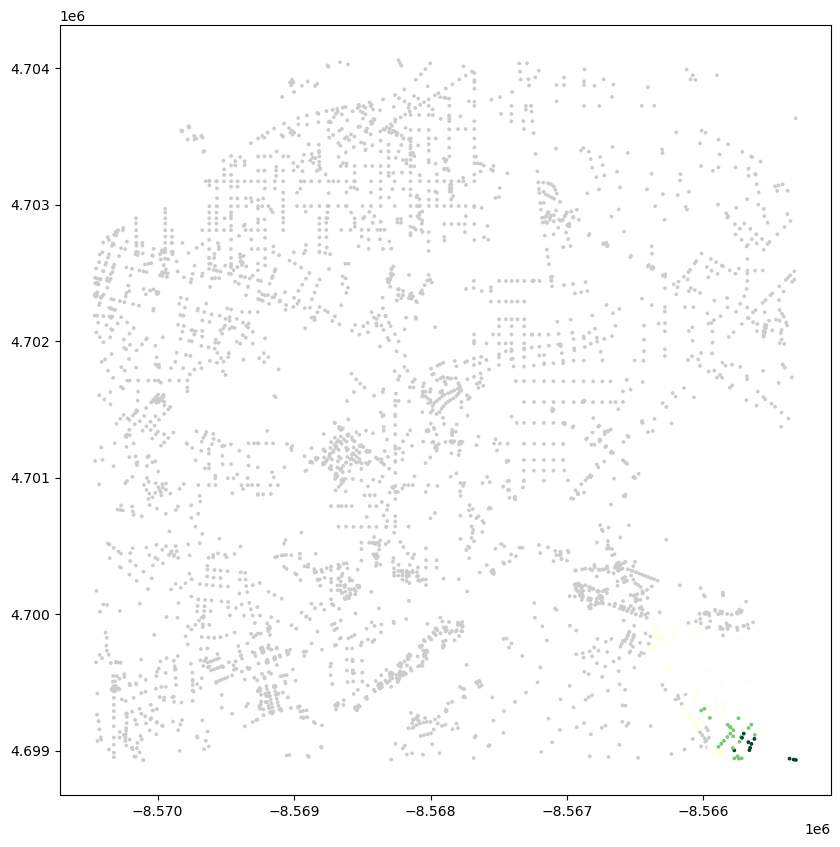

In [45]:
gdf_nodes.plot(figsize=(10,10),
               color=gdf_nodes['color'],
               markersize=3,
               )

No idea why the map is so off center? Let's see if it affects the final product I actually want, which is the polygon.

## Creating the Polygons

First, I'll start out with creating the polygon around points for 5 minute walking distance.

In [46]:
gdf_5 = gdf_nodes[gdf_nodes['time']==5]

Let's plot it and see what points are formed...

<AxesSubplot: >

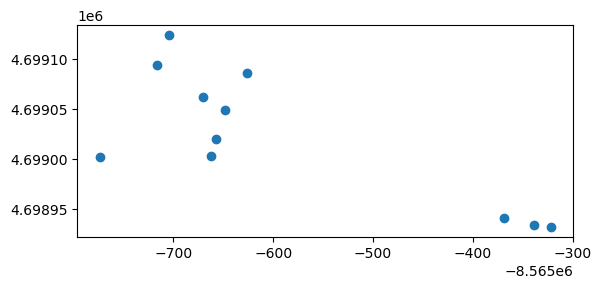

In [47]:
gdf_5.plot()

It doesn't seem like there are a lot of nodes nearby? Maybe it's disconnected from other parts of the city? Let's see what shape it forms using a convex-hull to connect the area between the nodes.

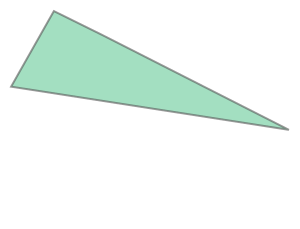

In [48]:
gdf_5.unary_union.convex_hull

Well....that's something. Let's hope the other shapes provide more insight into what's going on around this Safeway. I'll use dissolve for this next part to create polygons around the 5, 10, and 15 minute nodes.

In [49]:
isochrones = gdf_nodes.dissolve(by = "time")
isochrones

geometry             y  \
time                                                                    
5.0   MULTIPOINT (-8565773.494 4699001.674, -8565716...  4.698934e+06   
10.0  MULTIPOINT (-8566015.692 4699293.611, -8565992...  4.699294e+06   
15.0  MULTIPOINT (-8566427.563 4699693.197, -8566399...  4.699866e+06   

                 x  street_count        lon        lat          highway  \
time                                                                      
5.0  -8.565339e+06             3 -76.943748  38.841087             None   
10.0 -8.566016e+06             4 -76.949828  38.843602  traffic_signals   
15.0 -8.566110e+06             3 -76.950675  38.847607  traffic_signals   

        color  
time           
5.0   #004529  
10.0  #77c679  
15.0  #ffffe5

We'll convert each row into a convex hull now using the geometry of the multiple nodes.

In [50]:
isochrones = isochrones.convex_hull.reset_index(name='geometry')
isochrones

time                                           geometry
0   5.0  POLYGON ((-8565321.927 4698931.500, -8565773.4...
1  10.0  POLYGON ((-8565739.085 4698941.033, -8565772.9...
2  15.0  POLYGON ((-8565888.097 4698931.986, -8565936.0...

Now, I'll reverse the order so the 15 minute polygon is mapped first.

In [51]:
isochrones.sort_values(by='time', ascending=False,inplace=True)
isochrones

time                                           geometry
2  15.0  POLYGON ((-8565888.097 4698931.986, -8565936.0...
1  10.0  POLYGON ((-8565739.085 4698941.033, -8565772.9...
0   5.0  POLYGON ((-8565321.927 4698931.500, -8565773.4...

Time to plot it and see what is produces!

<AxesSubplot: >

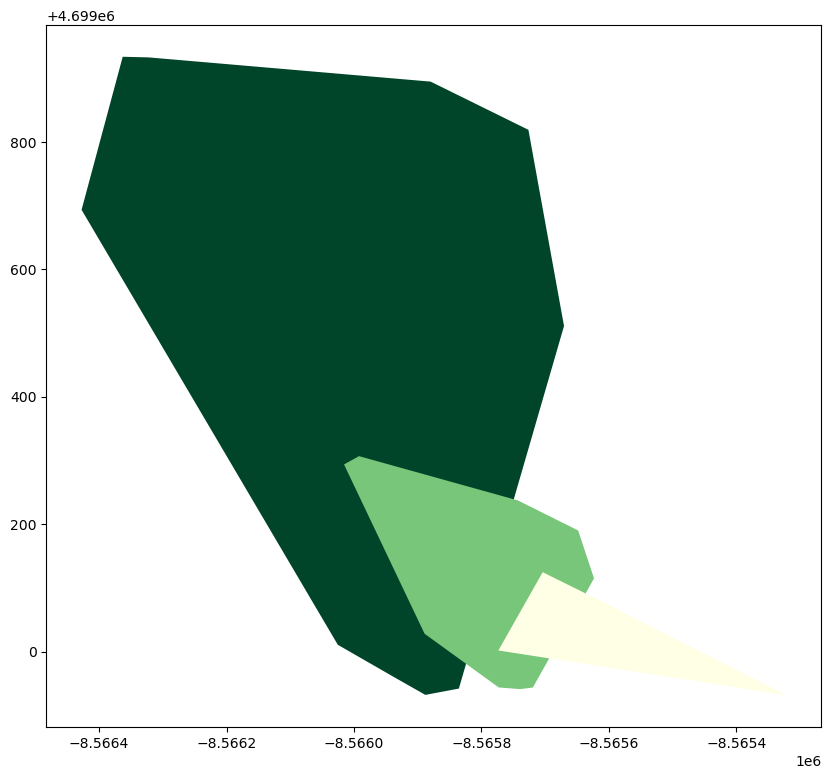

In [52]:
isochrones.plot(figsize=(10,10),alpha=1,color=new_colors, legend=True)

So it's a very interesting shape. It seems to suggest that the networks around this particular location are limited? Perhaps it's located on the edges of Washington, DC so it serves parts of Maryland as well. Let's map it with a basemap to find out.

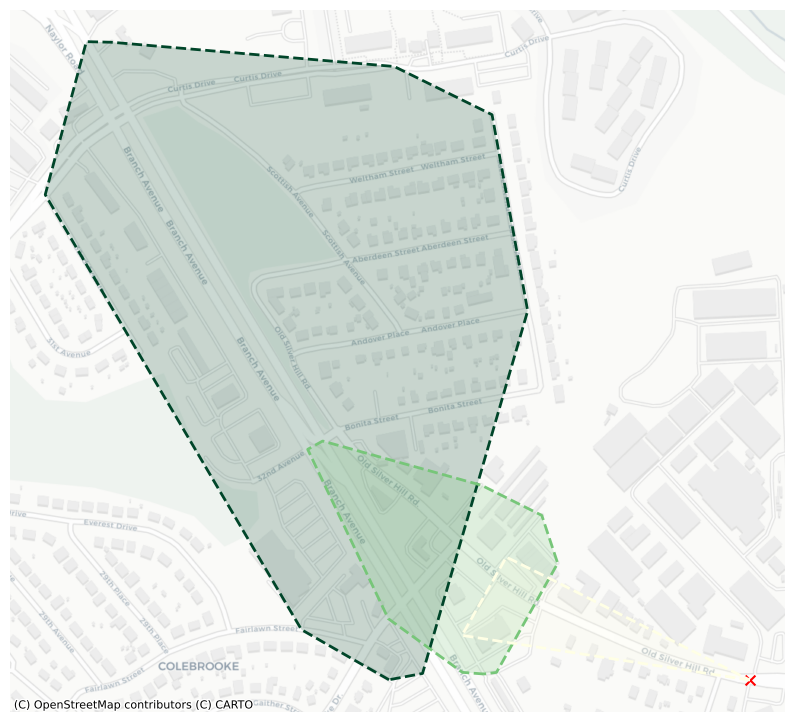

In [53]:
# set up the subplots
fig, ax = plt.subplots(figsize=(10,15))

# add the isochrone boundary
isochrones.boundary.plot(
    ax=ax,
    alpha=1,
    linestyle='--',
    color=new_colors,
    lw=2
    ) 

# add the isochrones
isochrones.plot(
    ax=ax, 
    alpha=0.2, 
    categorical=True, # even though it is numeric, treat it as categorical
    color=new_colors,
    )

# add the center node in red
gdf_nodes.loc[[safeway_node]].plot(ax=ax,color='r',marker='x',markersize=50)

# hide the axis
ax.axis('off')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

So this seems wrong? Like there definitely should be coverage to the north, south, and east of this grocery store point? Looking at Google Maps, there are other points that should havee been included in this safeway. I'm very confused. For my next steps, I want to figure out what went wrong with this map. The next steps for this project will be 1) Figuring out what went wrong here, 2) How to apply a for loop or function to be able to calculate these polygons for every grocery store in Washington DC. 

For later, here's an attempt at integrating a for loop to map isochrones for grocery stores. It was unsuccessful, but I can come back to this later.

https://stackoverflow.com/questions/58444333/iterating-over-an-isochrone-in-osmnx-in-python

In [54]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
ox.config(log_console=True, use_cache=True)
ox.__version__

# get one color for each isochrone
iso_colours = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

#info for later on
network_type = 'walk'
trip_times = [5, 10, 15]
meters_per_minute = 75

# isochrone function
def make_iso_polys(G, centre_node, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, centre_node, radius=trip_time, distance='time')

        node_points = [Point((grocery_trimmed['Y'], grocery_trimmed['X'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

# the area 
mv = ox.graph_from_bbox(-37.705, -37.796, 144.949, 144.84, network_type='walk')
mv_projected = ox.project_graph(mv)
ox.plot_graph(mv_projected)

multiple_coords = ((-37.773981, 144.915669), 
                   (-37.765443, 144.863070), 
                   (-37.736089, 144.888972), 
                   (-37.764914, 144.924148), 
                   (-37.788513, 144.930533))

ModuleNotFoundError: No module named 'descartes'